# Wordle Analysis using Tweet data

## Data Preparation and Cleaning

In [17]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

### Source 1: Historical Wordle Answers
- Scrape a website for all the historical answers to Wordle (https://wordfinder.yourdictionary.com/wordle/answers/)
- 1,100 Wordle Answers as of July 2024 (n = ~1100)
- Clean the data
- Add features
  - Word Structure (vowels vs consonant)
  - Check if the word has repeating letters

In [19]:
from bs4 import BeautifulSoup
import requests

def fetch_wordle_answers(url):
    # parse HTML content from URL
    page = requests.get(url)
    html = BeautifulSoup(page.content, 'html.parser')

    all_rows = []

    # find all tables on the webpage
    tables = html.find_all('table')

    # loop through each table/row in table
    for table in tables:
        rows = table.find_all('tr')
        for row in rows:
            row_data = [cell.get_text(strip=True) for cell in row.find_all(['td', 'th'])]
            all_rows.append(row_data)
    
    wordle_answers = pd.DataFrame(all_rows)
    return clean_wordle_answers(wordle_answers)


def clean_wordle_answers(df):
    return (df
     .rename(columns=df.iloc[0])
     .rename(columns = lambda c: c.replace(' ', '_').lower())
     .rename(columns = {'wordle_#': 'wordle_id'})
     .loc[:,['wordle_id','answer']] # 'date'
     .query("answer != 'Answer'") # filter out the rows with column names (the original data was a set of multiple tables)
     .reset_index(drop = True)
     .pipe(lambda df: df.assign(
         # date = df.date
         #     .str.replace('Today', ''),
         wordle_id = df.wordle_id
             .astype('int32[pyarrow]'),
         answer = df.answer
             .str.replace('Reveal', ''),
         word_structure = lambda df: df
             .answer.apply(get_word_structure),
         repeat_letters = lambda df: df
             .answer.apply(check_repeating_letters)
     )
          )
    ) 


def get_word_structure(word):
    # convert word into vowel/consonant labels (ex: CLEAN = CCVVC)
    vowels = set('aeiou')
    structure = []
    for letter in word:
        if letter.lower() in vowels:
            structure.append('V')
        else:
            structure.append('C')
    return ''.join(structure)


def check_repeating_letters(word):
    seen_letters = set()
    for letter in word:
        if letter in seen_letters:
            return True
        seen_letters.add(letter)
    return False

url = 'https://wordfinder.yourdictionary.com/wordle/answers/'
wordle_answers = fetch_wordle_answers(url)

### Source 2: Potential Wordle Answers
- Scrape a website for all the potential answers to Wordle (https://www.wordunscrambler.net/word-list/wordle-word-list)
- There are ~2,100 potential Wordle Answers (n = ~2,100)
- Clean the data

In [21]:
def fetch_words(url):
    # parse HTML content from URL
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')

    # collect all wordle words on webpage by filtering for <li class="invert light'>
    words = html.find_all('li', class_='invert light')
    
    all_words = []
    
    for word in words:
        word = word.find('a').text.strip()
        all_words.append(word)

    # change all words to upper case
    all_words = [word.upper() for word in all_words]

    # turn list into series
    return pd.Series(all_words, name = 'all_words')
 
url = 'https://www.wordunscrambler.net/word-list/wordle-word-list'
all_words = fetch_words(url)

In [22]:
# Merge historical answers and potential words to create a valid list of wordle answers
valid_words = (
    pd.merge(
        wordle_answers['answer'], 
        all_words, 
        left_on = 'answer', 
        right_on = 'all_words', 
        how = 'outer', 
        indicator = True)
    .query("_merge == 'right_only'")
    .loc[:,['all_words']]
    .reset_index(drop = True)
    .astype('Str[pyarrow]')
    .squeeze()
    #.tolist()
)

### Source 3: Wordle Plays from Tweets collected in a Kaggle dataset
- Download Wordle Tweets dataset from Kaggle (https://www.kaggle.com/datasets/benhamner/wordle-tweets/data)
  - Dataset is a collection of Tweets circa 2022
  - Number of Tweets pulled per day is fixed and doesn't represent all Wordle Tweets
  - ~1.1 mil Tweets (n = ~1100000)
  - Only Tweets where the Wordle was successful solved were collected
- Clean the data
  - Different Twitter users have different color Wordle sets
  - Clean/drop Tweets that are not in the standard 'share' format
  - Parse the Tweets for information
  - Merge with historical answers

In [24]:
# Import dataset and assign to tweets
tweets = pd.read_csv(r"C:\Users\cneva\Projects\Wordle\wordle-tweets\tweets.csv")

In [25]:
def clean_tweets(df):
    df = \
    (df
     .loc[:,['wordle_id', 'tweet_text',]] #' tweet_id', 'tweet_date', 'tweet_username']]
     .query("~tweet_text.str.contains('🟧') and ~tweet_text.str.contains('🟦') and ~tweet_text.str.contains('🟪')")
     .merge(wordle_answers, how = 'left', on = 'wordle_id')
     .assign(
         # assign whatever is in the last line of the tweet as a comment
         comments = lambda df: df.tweet_text 
             .str.split('\n')
             .str[-1]
             .where(~df.tweet_text.str[-1].str.contains('🟩|🟨|⬛', regex = True)), # if it does not contain box, add to commment
         n_attempts = lambda df: df.tweet_text
             .str.split('\n')
             .str[0]
             .str.split("/6").str[0]
             .str.split(" ").str[2]
             .astype('int8[pyarrow]'),
         attempt_all = lambda df: df.tweet_text
             .str.replace('⬜','⬛')
             .apply(filter_row)
             .str.findall('.{1,5}')
     )
     .drop(['tweet_text'], axis = 1)
     .reset_index(drop = True)
     .pipe(parse_attempts)
     .pipe(drop_anomalous_rows)
    )
    return df


def parse_attempts(df):
    # Separate each attempt in the attempt text (ex. [⬛⬛🟨🟨⬛, 🟩⬛⬛⬛⬛, 🟩🟩🟨⬛⬛, 🟩🟩🟩🟩🟩])
    # For each 6 attempts, count the 3 different blocks
    
    for n in range(6):
        df[f'attempt_{n + 1}'] = df.attempt_all.str[n].fillna('Completed')
        df[f'attempt_{n + 1}_green'] = df[f'attempt_{n + 1}'].replace('Completed',np.nan).str.count('🟩').astype('int8[pyarrow]')
        df[f'attempt_{n + 1}_yellow'] = df[f'attempt_{n + 1}'].replace('Completed',np.nan).str.count('🟨').astype('int8[pyarrow]')
        df[f'attempt_{n + 1}_grey'] = df[f'attempt_{n + 1}'].replace('Completed',np.nan).str.count('⬛').astype('int8[pyarrow]')
        n += 1
        
    return df
    

def drop_anomalous_rows(df):
    # (1) Loops through the 6 attempts and drops rows of tweets where the length 
    #     of the string is not equal to 5 characters
    # (2) Also collects indexes where the last attempt is not GGGGG 
    #     ex.) if n_attempts = 4 and attempt_green_4 != 5, then drop
    # (3) Also drops rows where attempt_6 is not all green as tweets supposedly 
    #     are only fully successful plays
    # (A) Avoids warning -> "RuntimeWarning: Engine has switched to 'python' because 
    #     numexpr does not support extension array dtypes. Please set your engine 
    #     to python manually."
    
    
    pd.set_option('compute.use_numexpr', False) # (A)
    drop_list = []
    
    for i in range(6):
        df = \
            (df.query(
                f"(attempt_{6-i}.str.len() == 5) or (attempt_{6 - i} == 'Completed')")
             .reset_index(drop = True)) # (1)
        drop_list += \
            list(df.query(
                f"(n_attempts == {6 + i}) and ((attempt_{6 - i}_green != 5) or attempt_{6 - i} == 'Completed')")
                 .index) # (2)
        df = df.drop(index = drop_list).reset_index(drop = True)
        i += 1

    
    df = df.drop(index = list(df.query("(n_attempts != 6) and (attempt_6_green != 5) and (attempt_6 != 'Completed')").index))
    df = df.reset_index(drop = True) # (3)
    
    pd.set_option('compute.use_numexpr', True)
    
    return df
    

def filter_row(row):
    filtered_text = [char for char in row if char in ['🟩', '🟨', '⬛']]
    return ''.join(filtered_text)

In [26]:
tweets = clean_tweets(tweets)
tweets

,wordle_id,answer,word_structure,repeat_letters,comments,n_attempts,attempt_all,attempt_1,attempt_1_green,attempt_1_yellow,attempt_1_grey,attempt_2,attempt_2_green,attempt_2_yellow,attempt_2_grey,attempt_3,attempt_3_green,attempt_3_yellow,attempt_3_grey,attempt_4,attempt_4_green,attempt_4_yellow,attempt_4_grey,attempt_5,attempt_5_green,attempt_5_yellow,attempt_5_grey,attempt_6,attempt_6_green,attempt_6_yellow,attempt_6_grey
0,210,PANIC,CVCVC,False,NaN,4,"[⬛⬛🟨🟨⬛, 🟩⬛⬛⬛⬛, 🟩🟩🟨⬛⬛, 🟩🟩🟩🟩🟩]",⬛⬛🟨🟨⬛,0,2,3,🟩⬛⬛⬛⬛,1,0,4,🟩🟩🟨⬛⬛,2,1,2,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
1,210,PANIC,CVCVC,False,NaN,4,"[⬛⬛⬛⬛⬛, 🟩🟩🟨🟨⬛, 🟩🟩⬛🟩🟨, 🟩🟩🟩🟩🟩]",⬛⬛⬛⬛⬛,0,0,5,🟩🟩🟨🟨⬛,2,2,1,🟩🟩⬛🟩🟨,3,1,1,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
2,210,PANIC,CVCVC,False,NaN,4,"[⬛⬛⬛🟨⬛, ⬛🟩⬛🟨⬛, ⬛🟩⬛🟨⬛, 🟩🟩🟩🟩🟩]",⬛⬛⬛🟨⬛,0,1,4,⬛🟩⬛🟨⬛,1,1,3,⬛🟩⬛🟨⬛,1,1,3,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
3,210,PANIC,CVCVC,False,NaN,3,"[⬛⬛🟨⬛⬛, 🟨🟨⬛⬛⬛, 🟩🟩🟩🟩🟩]",⬛⬛🟨⬛⬛,0,1,4,🟨🟨⬛⬛⬛,0,2,3,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
4,210,PANIC,CVCVC,False,NaN,3,"[⬛⬛🟨⬛⬛, 🟩🟩🟩⬛⬛, 🟩🟩🟩🟩🟩]",⬛⬛🟨⬛⬛,0,1,4,🟩🟩🟩⬛⬛,3,0,2,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174774,519,BRAVE,CCVCV,False,NaN,2,"[⬛🟩🟨🟨⬛, 🟩🟩🟩🟩🟩]",⬛🟩🟨🟨⬛,1,2,2,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
1174775,519,BRAVE,CCVCV,False,NaN,3,"[⬛🟨🟩🟨⬛, ⬛🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]",⬛🟨🟩🟨⬛,1,2,2,⬛🟩🟩🟩🟩,4,0,1,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
1174776,519,BRAVE,CCVCV,False,NaN,3,"[⬛🟩🟩⬛🟩, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",⬛🟩🟩⬛🟩,3,0,2,🟩🟩🟩⬛🟩,4,0,1,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>
1174777,519,BRAVE,CCVCV,False,I play #wordle better when the ⁦@Bengals⁩ win!...,3,"[🟨🟩⬛⬛🟩, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",🟨🟩⬛⬛🟩,2,1,2,🟩🟩🟩⬛🟩,4,0,1,🟩🟩🟩🟩🟩,5,0,0,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>,Completed,<NA>,<NA>,<NA>


## Analysis

In [28]:
import matplotlib.pylab as plt
import seaborn as sns

#plt.style.use("bmh")
color_pal = plt.get_cmap('tab10').colors

### 1.) Average Results by Attempt
- The average first attempt has 0.5 correct, 1 close, and 3.5 incorrects
- On average it takes 4.13 attempts to solve Wordle
- Fig 1 and Fig 2 show the average result by attempt #, plotted in two different ways

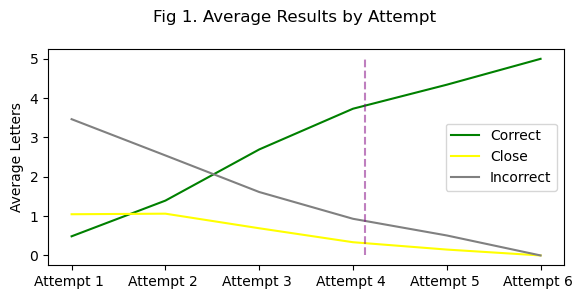

In [30]:
fig_1, ax_1 = plt.subplots(figsize=(6, 3))

# take the mean for each column (attempt_1_green, attempt_3_yellow, etc) and plot
for i, x in enumerate(['green','yellow','grey']):

    # collect all columns in df tweets that contain 'green', 'yellow', or 'grey'
    columns = [c for c in tweets.columns if x in c]
    title = [i for i in ['Correct', 'Close', 'Incorrect']]
    
    (tweets
     .loc[:,columns]
     .mean()
     .sort_index(ascending = True)
     .rename(lambda ser: ser.replace(f'{x}',f'').replace('_',' ').title())
     .plot(
         ax = ax_1,
         color = x,
         label = title[i]
     )
    )
average_attempts = tweets.n_attempts.mean()
ax_1.vlines(average_attempts - 1 , 0 ,5, alpha = 0.5, color = 'purple', linestyle = 'dashed')

fig_1.suptitle('Fig 1. Average Results by Attempt', fontsize=12)
plt.legend()
plt.ylabel('Average Letters')
plt.tight_layout()
plt.style.use('dark_background')
plt.show()

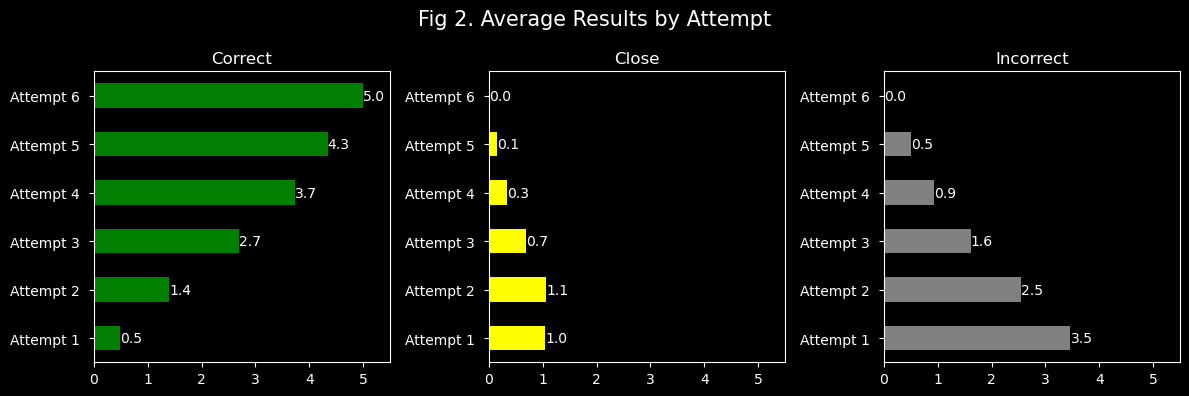

In [31]:
fig_2, ax_2 = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for i, x in enumerate(['green','yellow','grey']):

    columns = [c for c in tweets.columns if x in c]
    title = [i for i in ['Correct', 'Close', 'Incorrect']]
    
    (tweets
     .loc[:,columns]
     .mean()
     #.reindex(index = labels)
     .sort_index(ascending = True)
     .rename(lambda ser: ser.replace(f'{x}',f'').replace('_',' ').title())
     .plot(
         kind = 'barh',
         ax = ax_2[i],
         title = title[i],
         color = x
     )
    )
    #ax_2[i].set_xlabel('Average Letters')

for ax in ax_2:
    ax.bar_label(ax.containers[0], fmt='%.1f')
    ax.set_xlim(0, 5.5)

fig_2.suptitle('Fig 2. Average Results by Attempt', fontsize=15)
plt.tight_layout()
plt.style.use('dark_background')
plt.show()


### 2.) Answer Difficulty vs Number of Tweets
- Is there a correlation between how difficult a Wordle answers is and number of Tweets? The thought is that more people will tweet about their Wordle game if they completed it
- Difficulty is calculated by the average number of attempts it took
- The approach is flawed because the Tweets dataset is a fixed number of Tweets and not representative of how many people tweet wordle in a day
    - (Correlation between average Attempts and number of Tweets is -0.10279002398625792) 


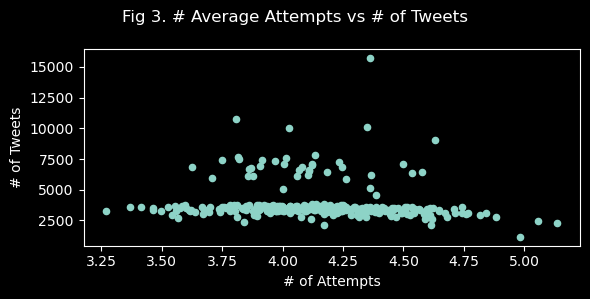

In [33]:
fig_3, ax_3 = plt.subplots(figsize=(6, 3))

(tweets
 .groupby('answer')
 .agg(
     average_attempts = ('n_attempts', 'mean'),
     tweet_count = ('n_attempts', 'count'))
 .plot(
     kind = 'scatter',
     x = 'average_attempts',
     y = 'tweet_count',
     ax = ax_3,     
 )
)

plt.xlabel('# of Attempts')
plt.ylabel('# of Tweets')
fig_3.suptitle('Fig 3. # Average Attempts vs # of Tweets', fontsize=12)
plt.tight_layout()
plt.show()



In [34]:
df_ = (tweets
 .groupby('answer')
 .agg(
     average_attempts = ('n_attempts', 'mean'),
     tweet_count = ('n_attempts', 'count'))
)

corr_ = df_['average_attempts'].corr(df_['tweet_count'])
print(f"Correlation between columns average Attempts and number of Tweets is {corr_}")

Correlation between columns average Attempts and number of Tweets is -0.10279002398625792


### 3.) Easiest/Hardest Wordle Answers
- A list of the easiest and hardest Wordle answers based on the number of attempts
    - Can call top_bottom_n(n) where n = number of words in graph
- Very interesting to see how each word ended up on each list!
    - For example, niche words like COYLY and GAWKY in hardest
    - I personally find myself taking longer when the word contains repeat letters
    - This is represented in words such as MUMMY, BOOZE
    - The easiest words appear to have a pattern of very common letters such as T, E, and A

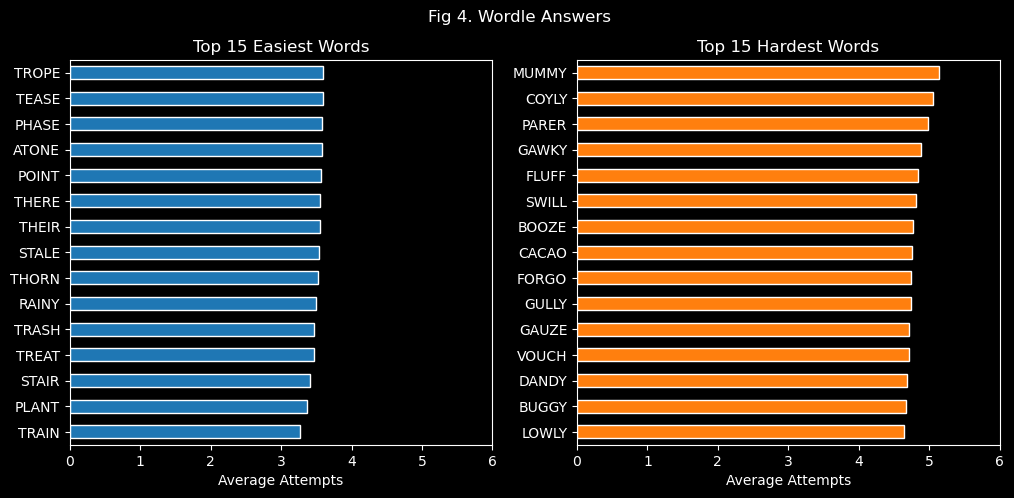

In [36]:
def top_bottom_n(n = 10):
    fig_4, ax_4 = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    title = [f'Top {n} Easiest Words', f'Top {n} Hardest Words']
    for i in range(2):
        (tweets
         .groupby('answer')
         .agg(average_attempts = ('n_attempts', 'mean'))
         .sort_values(by = 'average_attempts', ascending = True)
         .pipe(lambda df: df.head(n) if i == 0 else df.tail(n))
         .plot(
             kind = 'barh',
             ax = ax_4[i],
             ylabel = '',
             color = color_pal[i],
             title = title[i],
             xlabel = 'Average Attempts',
             edgecolor = 'white'
         )
         .legend().remove()
        )
        i += 1

    plt.suptitle('Fig 4. Wordle Answers', fontsize=12)
    plt.xlim(0,6)
    plt.show()


top_bottom_n(15)

### 4.) Word Structure
- Does the structure of the 5 letter Wordle word matter?
- Word structure in this case is the placement of vowels and consonants ex.) BRAIN -> CCVVC
- For example i find words that have a vowel in the first position to take a little longer to solve
- There are a group of common word structures that seem to have lower average attempt rates

In [38]:
def create_word_structure_df(df):

    # groupby word structure & answer
    df1 = \
    (df
     .groupby(['word_structure', 'answer'])
     .agg(average_attempts=('n_attempts', 'mean'))
     .reset_index()
     .groupby('word_structure')
     .apply(lambda x: x.loc[x['average_attempts'].idxmax(), ['answer', 'average_attempts']], include_groups=False)
     .rename(columns={'answer': 'most_difficult_word', 'average_attempts': 'most_difficult_word_attempts'})
     .reset_index()
    )
    
    # groupby word structure
    df2 = \
    (df
     .groupby('word_structure')
     .agg(
         average_attempts = ('n_attempts', 'mean'),
         tweet_count = ('answer', 'count'),
         unique_answers = ('answer', 'nunique'),
     )
     .reset_index()
    )
    
    # merge dfs
    return (pd.merge(df1, df2)
            .loc[:,['word_structure','average_attempts','most_difficult_word','most_difficult_word_attempts','tweet_count','unique_answers']]
            .sort_values(by = 'average_attempts')
            .set_index('word_structure')
           )

In [39]:
create_word_structure_df(tweets)

,average_attempts,most_difficult_word,most_difficult_word_attempts,tweet_count,unique_answers
word_structure,,,,,
CCVVC,3.958228,GLOOM,4.410526,102222,28
CCVCV,3.978538,PRIZE,4.583442,120727,31
CVVCC,4.022993,VOUCH,4.710349,114950,28
VCCCC,4.026423,APTLY,4.028156,6850,2
CCVCC,4.053324,FLUFF,4.842240,197005,51
CCCCV,4.053497,RHYME,4.112842,6748,2
VCVVC,4.080468,AHEAD,4.231860,13757,3
CCCCC,4.087121,NYMPH,4.183480,9263,3
VCVCV,4.091126,OXIDE,4.645752,33887,9


### 5.) Letter Position vs Attempt # 
- Is there a different solve rate for each position in the Wordle word?
- Among the position the Position 2 seems to be solved first compared to the other positions

In [41]:
def count_green(df):
    # initialize dataframe
    total_counts = pd.DataFrame(
        columns = [f'Position {i + 1}' for i in range(5)],
        index = [f'Attempt {k + 1}' for k in range(6)]
    )
    
    for k in range(6):
        for i in range(5):
            count_green = df[f'attempt_{k + 1}'].str[i].str.contains('🟩').sum()
            count_completed = df[f'attempt_{k + 1}'].str.contains('Completed').sum()
            total_counts.at[f'Attempt {k + 1}', f'Position {i + 1}'] = count_green + count_completed
            i += 1
        k += 1
    
    return total_counts.astype('int64[pyarrow]')

In [42]:
count_green_df = count_green(tweets)
count_green_df.style.background_gradient(cmap='Greens', axis = 1)

,Position 1,Position 2,Position 3,Position 4,Position 5
Attempt 1,102663,115042,125234,95493,133490
Attempt 2,300377,375846,356205,281968,323765
Attempt 3,604148,744376,698646,624947,653516
Attempt 4,912252,1018554,980690,944193,964565
Attempt 5,1098950,1137133,1122557,1112341,1122458
Attempt 6,1174779,1174779,1174779,1174779,1174779


### 6.) Repeating Letters
- Does repeating letters in the Wordle word make it more difficult?
- Based on the Independent T-Test, at 𝛼 = 0.05, there is a significant difference in difficulty between words with repeat letters and words without

In [44]:
(tweets
 .groupby('repeat_letters')
 .agg(
     average_attempts = ('n_attempts', 'mean'),
     std_dev = ('n_attempts', 'std')
     )
)

,average_attempts,std_dev
repeat_letters,,
False,4.051642,1.07659
True,4.330346,1.054451


In [45]:
import scipy.stats as stats

# subset the data
has_repeats = tweets.query("repeat_letters == True").n_attempts
no_repeats = tweets.query("repeat_letters == False").n_attempts

# check variance of samples
print("var(has_repeats) = ", np.var(has_repeats), " | var(no_repeats) = ",  np.var(no_repeats), )

# t-test
t_stat, p_value = stats.ttest_ind(has_repeats, no_repeats)
print(stats.ttest_ind(has_repeats, no_repeats))
print()

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference in difficulty between words with repeat letters and words without.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference in difficulty between words with repeat letters and words without.")

var(has_repeats) =  1.1118630902663102  | var(no_repeats) =  1.1590451553536425
TtestResult(statistic=124.52713033095262, pvalue=0.0, df=1174777.0)

Reject the null hypothesis; there is a significant difference in difficulty between words with repeat letters and words without.


### 7.) Most Correct Letters On First Attempt 
- Are there letters better to include in the First Attempt?
- By far vowels E and A have better success rates in the first attempt

In [47]:
import re

correct_letters = []

for i, d in tweets.dropna(subset=['answer']).iterrows():
    attempt_ = d['attempt_1']
    answer_ = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', attempt_)]
    first_attempt_letters = [answer_[i] for i in results]
    correct_letters += first_attempt_letters
    
first_letters = pd.Series(correct_letters).value_counts(ascending=True)

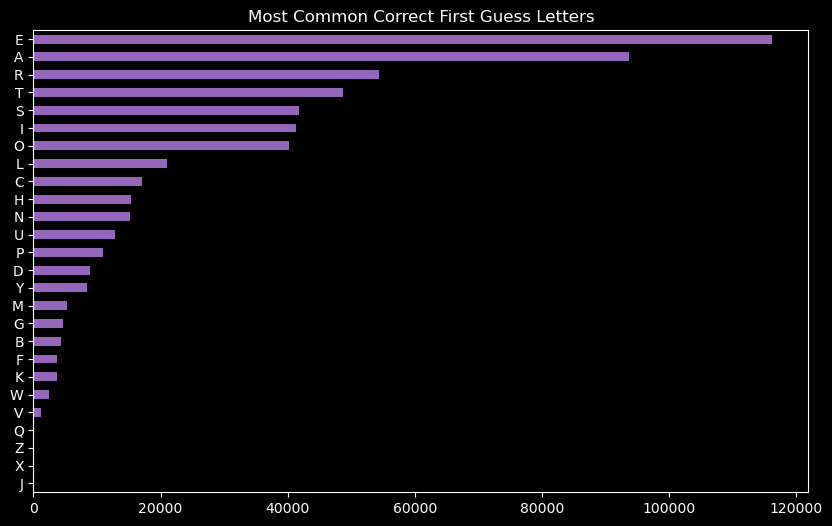

In [48]:
(first_letters
 .plot(
     kind='barh', figsize=(10, 6), 
     title='Most Common Correct First Guess Letters',
     color=color_pal[4]
 )
)
plt.show()


### 8.) Most Common Letters for Wordle Answers
- For the remaining subset of valid Wordle, what are the most common letters?

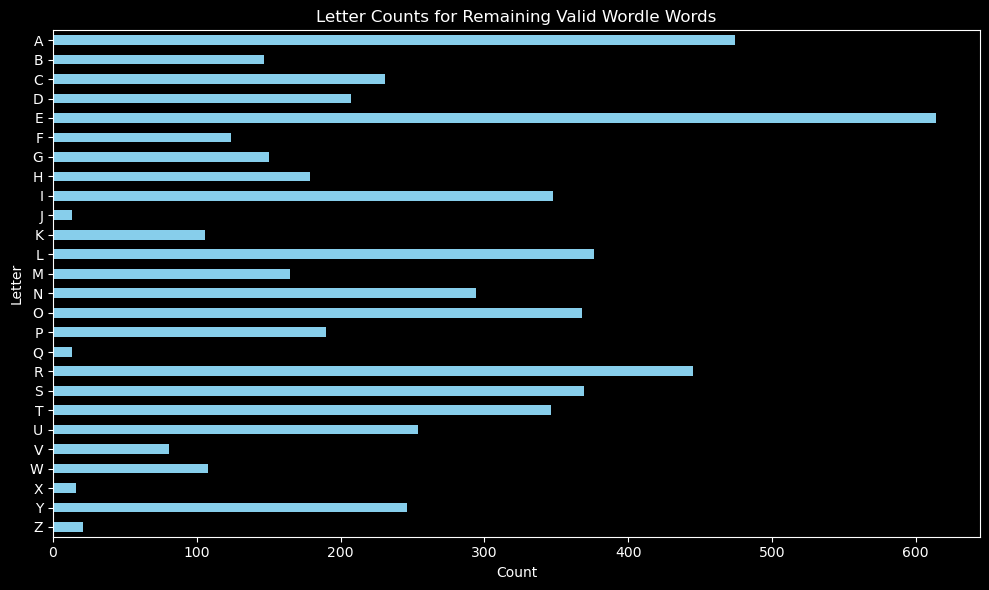

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize letter_count dictionary with all letters from 'a' to 'z' with count 0 and join all words into a single string
letter_count = {chr(i): 0 for i in range(ord('A'), ord('Z') + 1)}
joined_valid_words = ' '.join(valid_words)

# Count the occurrences of each letter
for letter in joined_valid_words:
    if letter.isalpha():  # Ensure we count only letters
        letter_count[letter.upper()] += 1

letter_series = pd.Series(letter_count)

plt.figure(figsize=(10, 6))
letter_series.sort_index(ascending = False).plot(kind='barh', color='skyblue')
plt.title('Letter Counts for Remaining Valid Wordle Words')
plt.xlabel('Count')
plt.ylabel('Letter')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 9.) Letter Count vs Count of Correct First Guess
- Are there any letters that historical have lower success rates but are in a higher percentage of words in the valid word pool?
- There does not seem to be any indication that future Wordle answers will deviate from the past Wordle answer patterns

In [52]:
first_letters_df = first_letters.reset_index().rename(columns = {'index': 'letter', 'count': 'first_guess_letters'})

combined_df = \
(letter_series
 .reset_index()
 .set_axis(['letter', 'count_valid_words'], axis=1)
 .merge(first_letters_df, how = 'outer')
 .assign(
     valid_perc = lambda df: (df['count_valid_words'] / df['count_valid_words'].sum()) * 100,
     first_guess_perc = lambda df: (df['first_guess_letters'] / df['first_guess_letters'].sum()) * 100
 )
)
combined_df

,letter,count_valid_words,first_guess_letters,valid_perc,first_guess_perc
0,A,474,93678,8.054376,16.379506
1,B,147,4358,2.497876,0.761992
2,C,231,17086,3.925234,2.987470
3,D,207,8956,3.517417,1.565948
4,E,614,116114,10.433305,20.302419
5,F,124,3764,2.107052,0.658132
6,G,150,4681,2.548853,0.818468
7,H,179,15398,3.041631,2.692325
8,I,348,41364,5.913339,7.232455
9,J,13,3,0.220901,0.000525


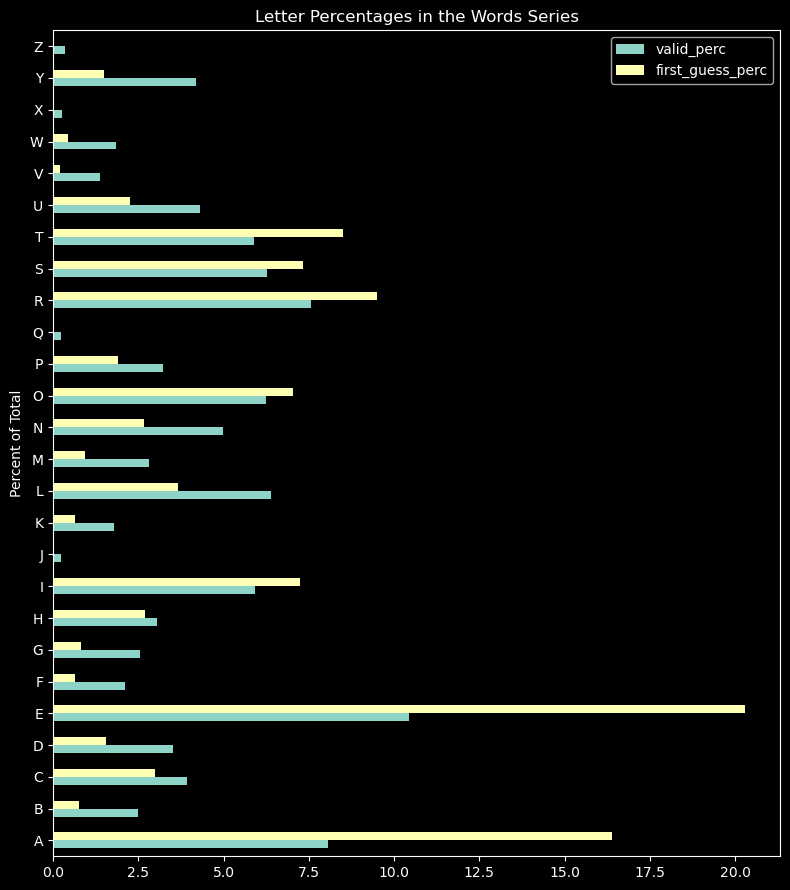

In [53]:
fig_4, ax_4 = plt.subplots(figsize=(8, 9))
(combined_df
 .plot(
     kind = 'barh',
     x = 'letter',
     y = ['valid_perc', 'first_guess_perc'],
     ax = ax_4
 )
)

plt.ylabel('Percent of Total')
plt.title('Letter Percentages in the Words Series')
plt.tight_layout()
plt.show()

### 10.) Good Starter Words
- There are many ways to calculate the best starting word to use for Wordle
- Some universally agreed upon good words are SALET, STARE, and CARET
- This list simply takes the list of future potential answers and gets a count for each letter. Using those
      counts, filter the future potential answers to words that contain those letters in each position

In [55]:
def find_good_word(n = 5):
    top_words = valid_words
    for i in range(5):
        letter_count = list(valid_words.str[i].value_counts().head(3).index)
        top_words = top_words[top_words.str[i].isin(letter_count)]
        i += 1
    
    return top_words

find_good_word(3)

228    CRIER
231    CRONY
Name: all_words, dtype: string[pyarrow]

##  Wordle Solver
- This Wordle helper filters the future potential Wordle answer list based on each word entered and the corresponding result
- Run wordle_helper() to begin! Instructions:
  - I enter CRONY as my first word
  - Wordle says the result is 🟩🟩🟨⬛⬛
  - I enter in ggybb
  - The helper returns a filtered list of valid words to use
  - Repeat this until you win!

In [57]:
def wordle_helper():
    g = ['_', '_', '_', '_', '_'] # green/correct letter and positions
    y_contains = [] # yellow, word contains letter
    y_position = ['_', '_', '_', '_', '_'] # yellow, correct letter but incorrect position
    b = [] # black, letter not in word
    filtered_words = all_words.dropna()
    k = 1 # Attempt number

    # Parse Input
    while any(char == '_' for char in g):
        input_word = list(input('Input Word: ').upper())
        results = list(input('Results: '))
    
        for i in range(5):
            if results[i] == 'g':
                g[i] = input_word[i]
            elif results[i] == 'y':
                y_position[i] = input_word[i]
                y_contains.append(input_word[i])

            elif results[i] == 'b':
                b.append(input_word[i])
            i += 1
    
        if y_contains is not None:
            y_contains = sorted(y_contains)
        if b is not None:
            b = sorted(b)

    # Filter green
        for i in range(5):
            if g[i] != '_':
                filtered_words = filtered_words[filtered_words.str[i] == g[i]]
            i += 1
    # Fiilter yellow by contain
        for i in range(len(y_contains)):
            filtered_words = filtered_words[filtered_words.str.contains(f"{y_contains[i]}")]
            i += 1
    # Filter yellow by position
        for i in range(5):
            if y_position[i] != '_':
                filtered_words = filtered_words[filtered_words.str[i] != y_position[i]]
            i += 1
    # Filter black
        for i in range(len(b)):
            filtered_words = filtered_words[~filtered_words.str.contains(f"{b[i]}")]
            i += 1

    # Print response
        print()
        print(f"Attempt ", {k})
        print("g:", g)
        print("y_contains:", y_contains)
        print("y_position:", y_position)
        print("b:", b)
        print("Available Words")
        print(*filtered_words, sep = ', ')
        k += 1

In [88]:
# Input Word = word entered in Wordle game
# Result: = the result from entering the Input Word. 
    # Ex.) ggybb = 🟩🟩🟨⬛⬛

wordle_helper()

Input Word:  corny
Results:  bgybb



Attempt  {1}
g: ['_', 'O', '_', '_', '_']
y_contains: ['R']
y_position: ['_', '_', 'R', '_', '_']
b: ['C', 'N', 'Y']
Available Words
BOARD, BOXER, GOURD, HOARD, HOMER, HOVER, JOKER, LOSER, LOVER, LOWER, MOLAR, MOTOR, MOVER, MOWER, POKER, POLAR, POSER, POWER, ROAST, ROBOT, RODEO, ROGER, ROGUE, ROOST, ROTOR, ROUGE, ROUGH, ROUSE, ROUTE, ROVER, ROWER, SOBER, SOLAR, SOWER, TOWER, VOTER, WOOER


Input Word:  board
Results:  bgyyb



Attempt  {2}
g: ['_', 'O', '_', '_', '_']
y_contains: ['A', 'R', 'R']
y_position: ['_', '_', 'A', 'R', '_']
b: ['B', 'C', 'D', 'N', 'Y']
Available Words
MOLAR, POLAR, SOLAR


Input Word:  solar
Results:  bgggg



Attempt  {3}
g: ['_', 'O', 'L', 'A', 'R']
y_contains: ['A', 'R', 'R']
y_position: ['_', '_', 'A', 'R', '_']
b: ['B', 'C', 'D', 'N', 'S', 'Y']
Available Words
MOLAR, POLAR


Input Word:  polar
Results:  ggggg



Attempt  {4}
g: ['P', 'O', 'L', 'A', 'R']
y_contains: ['A', 'R', 'R']
y_position: ['_', '_', 'A', 'R', '_']
b: ['B', 'C', 'D', 'N', 'S', 'Y']
Available Words
POLAR
